In [1]:
from profiler import Profiler, ListEvents
from collections import defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm
import os, time
from matplotlib import pyplot as plt

## Helper functions

In [2]:
flat_list= lambda x: [ g for f in x for g in f ]
double_list= lambda x: [[g] for g in x]
split_n= lambda x, n: [x[i:i + n] for i in range(0, len(x), n)]

def run_program(pargs, n=30, sample_period=0.05, reset_on_sample= True):
    try:
        all_data= []
        for i in tqdm(range(n)):
            program= Profiler(program_args=pargs, events_groups=to_monitor)
            data= program.run(sample_period=sample_period,reset_on_sample=reset_on_sample)
            all_data.append(data)
            #dfs.append(pd.DataFrame(data, columns=flat_list(to_monitor)))
    except RuntimeError as e:
        print(e.args[0])
    return all_data

## Events specifications

In [3]:
event_l= ListEvents()
all_events= event_l.get_event_description()
software_events= [e[0] for e in all_events if 'PERF_COUNT_SW' in e[0]]
hardware_events= [e[0] for e in all_events if 'PERF_COUNT_HW' in e[0]]
mem_events=[e[0] for e in all_events if 'MEM' in e[0] or 'CACHE' in e[0]]
rapl_events=['SYSTEMWIDE:'+e[0] for e in all_events if 'RAPL' in e[0]]
hw_groups= split_n(hardware_events, 5)

# Interrest
hw_events= double_list(['PERF_COUNT_HW_INSTRUCTIONS','PERF_COUNT_HW_BRANCH_INSTRUCTIONS','FP_COMP_OPS_EXE:X87',
                       'PERF_COUNT_HW_BRANCH_MISSES', 'PERF_COUNT_HW_CACHE_MISSES'])
mem_events= double_list(['MEM_UOPS_RETIRED:ALL_LOADS', 'MEM_UOPS_RETIRED:ALL_STORES'])
sw_events= [['PERF_COUNT_SW_CPU_CLOCK','PERF_COUNT_SW_PAGE_FAULTS','PERF_COUNT_SW_CONTEXT_SWITCHES',
                       'PERF_COUNT_SW_CPU_MIGRATIONS','PERF_COUNT_SW_PAGE_FAULTS_MAJ']]
rapl_events= double_list(rapl_events)
to_monitor= hw_events+mem_events+sw_events+rapl_events

for ev in flat_list(to_monitor):
    ev_split= ev.split(':')
    name= ev_split[1] if 'SYSTEMWIDE' in ev else ev_split[0]
    print( '%s: %s'%(name, event_l.get_event_description(name)[0][1]))
    if len(ev_split) > 1:
        for att in event_l.get_event_attrs(name):
            print('\t %s: %s'%(att[0],att[1]))

PERF_COUNT_HW_INSTRUCTIONS: PERF_COUNT_HW_INSTRUCTIONS
PERF_COUNT_HW_BRANCH_INSTRUCTIONS: PERF_COUNT_HW_BRANCH_INSTRUCTIONS
FP_COMP_OPS_EXE: Counts number of floating point events
	 X87: Number of X87 uops executed
	 SSE_FP_PACKED_DOUBLE: Number of SSE double precision FP packed uops executed
	 SSE_FP_SCALAR_SINGLE: Number of SSE single precision FP scalar uops executed
	 SSE_PACKED_SINGLE: Number of SSE single precision FP packed uops executed
	 SSE_SCALAR_DOUBLE: Number of SSE double precision FP scalar uops executed
	 e: edge level (may require counter-mask >= 1)
	 i: invert
	 c: counter-mask in range [0-255]
	 t: measure any thread
	 u: monitor at user level
	 k: monitor at kernel level
	 period: sampling period
	 freq: sampling frequency (Hz)
	 excl: exclusive access
	 mg: monitor guest execution
	 mh: monitor host execution
	 cpu: CPU to program
	 pinned: pin event to counters
PERF_COUNT_HW_BRANCH_MISSES: PERF_COUNT_HW_BRANCH_MISSES
PERF_COUNT_HW_CACHE_MISSES: PERF_COUNT_HW_CACHE

<h1>
    <a href="http://uops.info/table.html">UOPS- micro operations</a>
</h1>
<img src="pipeline.png" width=340> </img>
<p></p>

In [4]:
data= run_program(pargs=['polybench/covariance_MEDIUM_DATASET'])

100%|██████████| 30/30 [00:06<00:00,  4.56it/s]


In [30]:
def smooth_df(runs, cols_names):
    count_shapes= defaultdict(lambda:0)
    for r in runs:
        count_shapes[np.shape(r)]+=1
    moda_shape= max(count_shapes,key=count_shapes.get)
    
    print("Moda shape counts {:.2f}%".format(count_shapes[moda_shape]/sum(count_shapes.values())*100))
    data_moda= [d for d in runs if np.shape(d) == moda_shape]

    big_l= []
    for r in data_moda:
        big_l.append(np.array(r).reshape(-1))
    big_l= np.asarray(big_l)
    
    med_avg= []
    std_avg= []
    for s in range(big_l.shape[1]):
        median= np.sort(big_l[:,s])[3:-3]
        med_avg.append(median.mean())
        std_avg.append(median.std())
    
    med_avg= np.asarray(med_avg)
    std_avg= np.asarray(std_avg)
    
    med_avg= pd.DataFrame(med_avg.reshape(moda_shape), columns=cols_names)
    std_avg= pd.DataFrame(std_avg.reshape(moda_shape), columns=cols_names)
    
    return med_avg, std_avg

avg_df, std_df= smooth_df(data, flat_list(to_monitor))

Moda shape counts 90.00%


In [167]:
# counts= defaultdict(lambda:0)
# for df in dfs:
#     counts[df.shape]+=1
# moda_shape= max(counts,key=counts.get)
# print("Moda shape counts {:.2f}%".format(counts[moda_shape]/sum(counts.values())*100))
# dfs_moda= [df for df in dfs if df.shape == moda_shape]

# big_l= []
# for df in dfs_moda:
#     big_l.append(df.values.reshape(-1))
# big_l= np.asarray(big_l)

# med_avg= []
# for s in range(big_l.shape[1]):
#     median= np.sort(big_l[:,s])[3:-3]
#     med_avg.append(median.mean())
# med_avg= np.asarray(med_avg)
# smoth_df= pd.DataFrame(med_avg.reshape(moda_shape), columns=flat_list(to_monitor))
# smoth_df['PERF_COUNT_HW_INSTRUCTIONS'].plot()

10it [00:01,  6.42it/s]


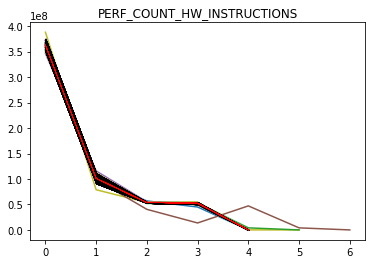

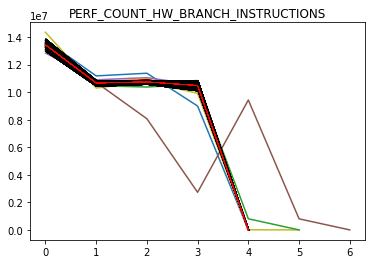

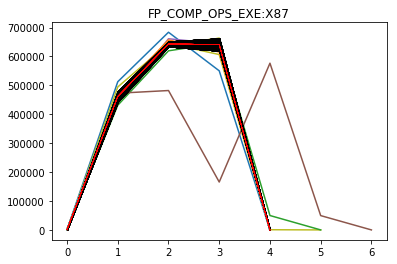

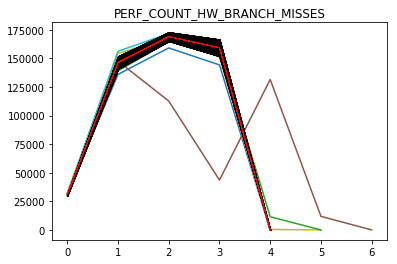

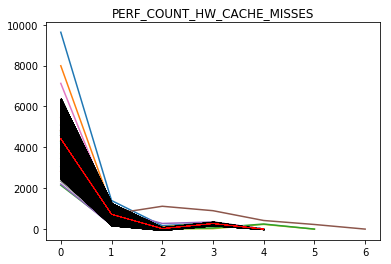

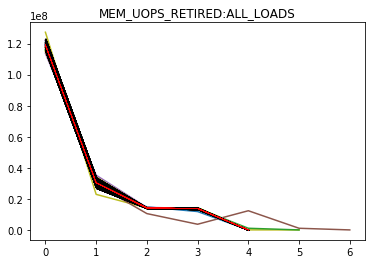

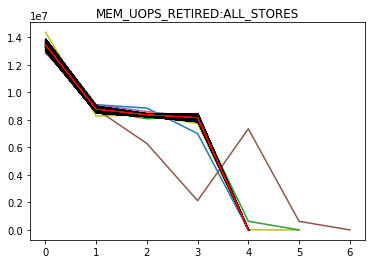

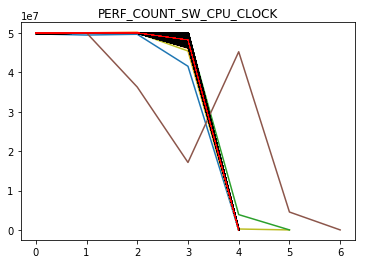

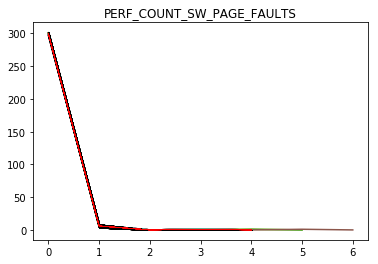

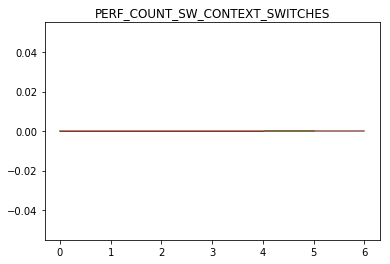

In [81]:
# for c in tqdm(dfs[0].columns):
#     plt.figure()
#     for df in dfs:
#         df[c].plot()
#         smoth_df[c].plot(linewidth=4,color='b')
#         plt.title(c)

for i, c in tqdm(enumerate(flat_list(to_monitor)[0:10])):
    plt.figure()
    for r in data:
        aux= np.array(r)
        plt.plot(aux[:,i],zorder=0)
        
        aux= avg_df[c].values
        aux_std= std_df[c].values
        plt.fill_between(np.arange(aux.shape[0]), aux-3*aux_std, aux+3*aux_std,color='k',zorder=1)
        plt.plot(aux,c='r',linewidth=0.5)
        #avg_df[c].plot(yerr=5*std_df[c].values)
        #avg_df[c].plot.area()
        #plt.plot(avg_df[c].values,xerr=std_df[c].values,linewidth=1,color='k')
        #plt.plot(avg_df[c].values+3*std_df[c].values, c='b')
        #plt.plot(avg_df[c].values-3*std_df[c].values, c='r')
    plt.title(c)

/home/vitor/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home/vitor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


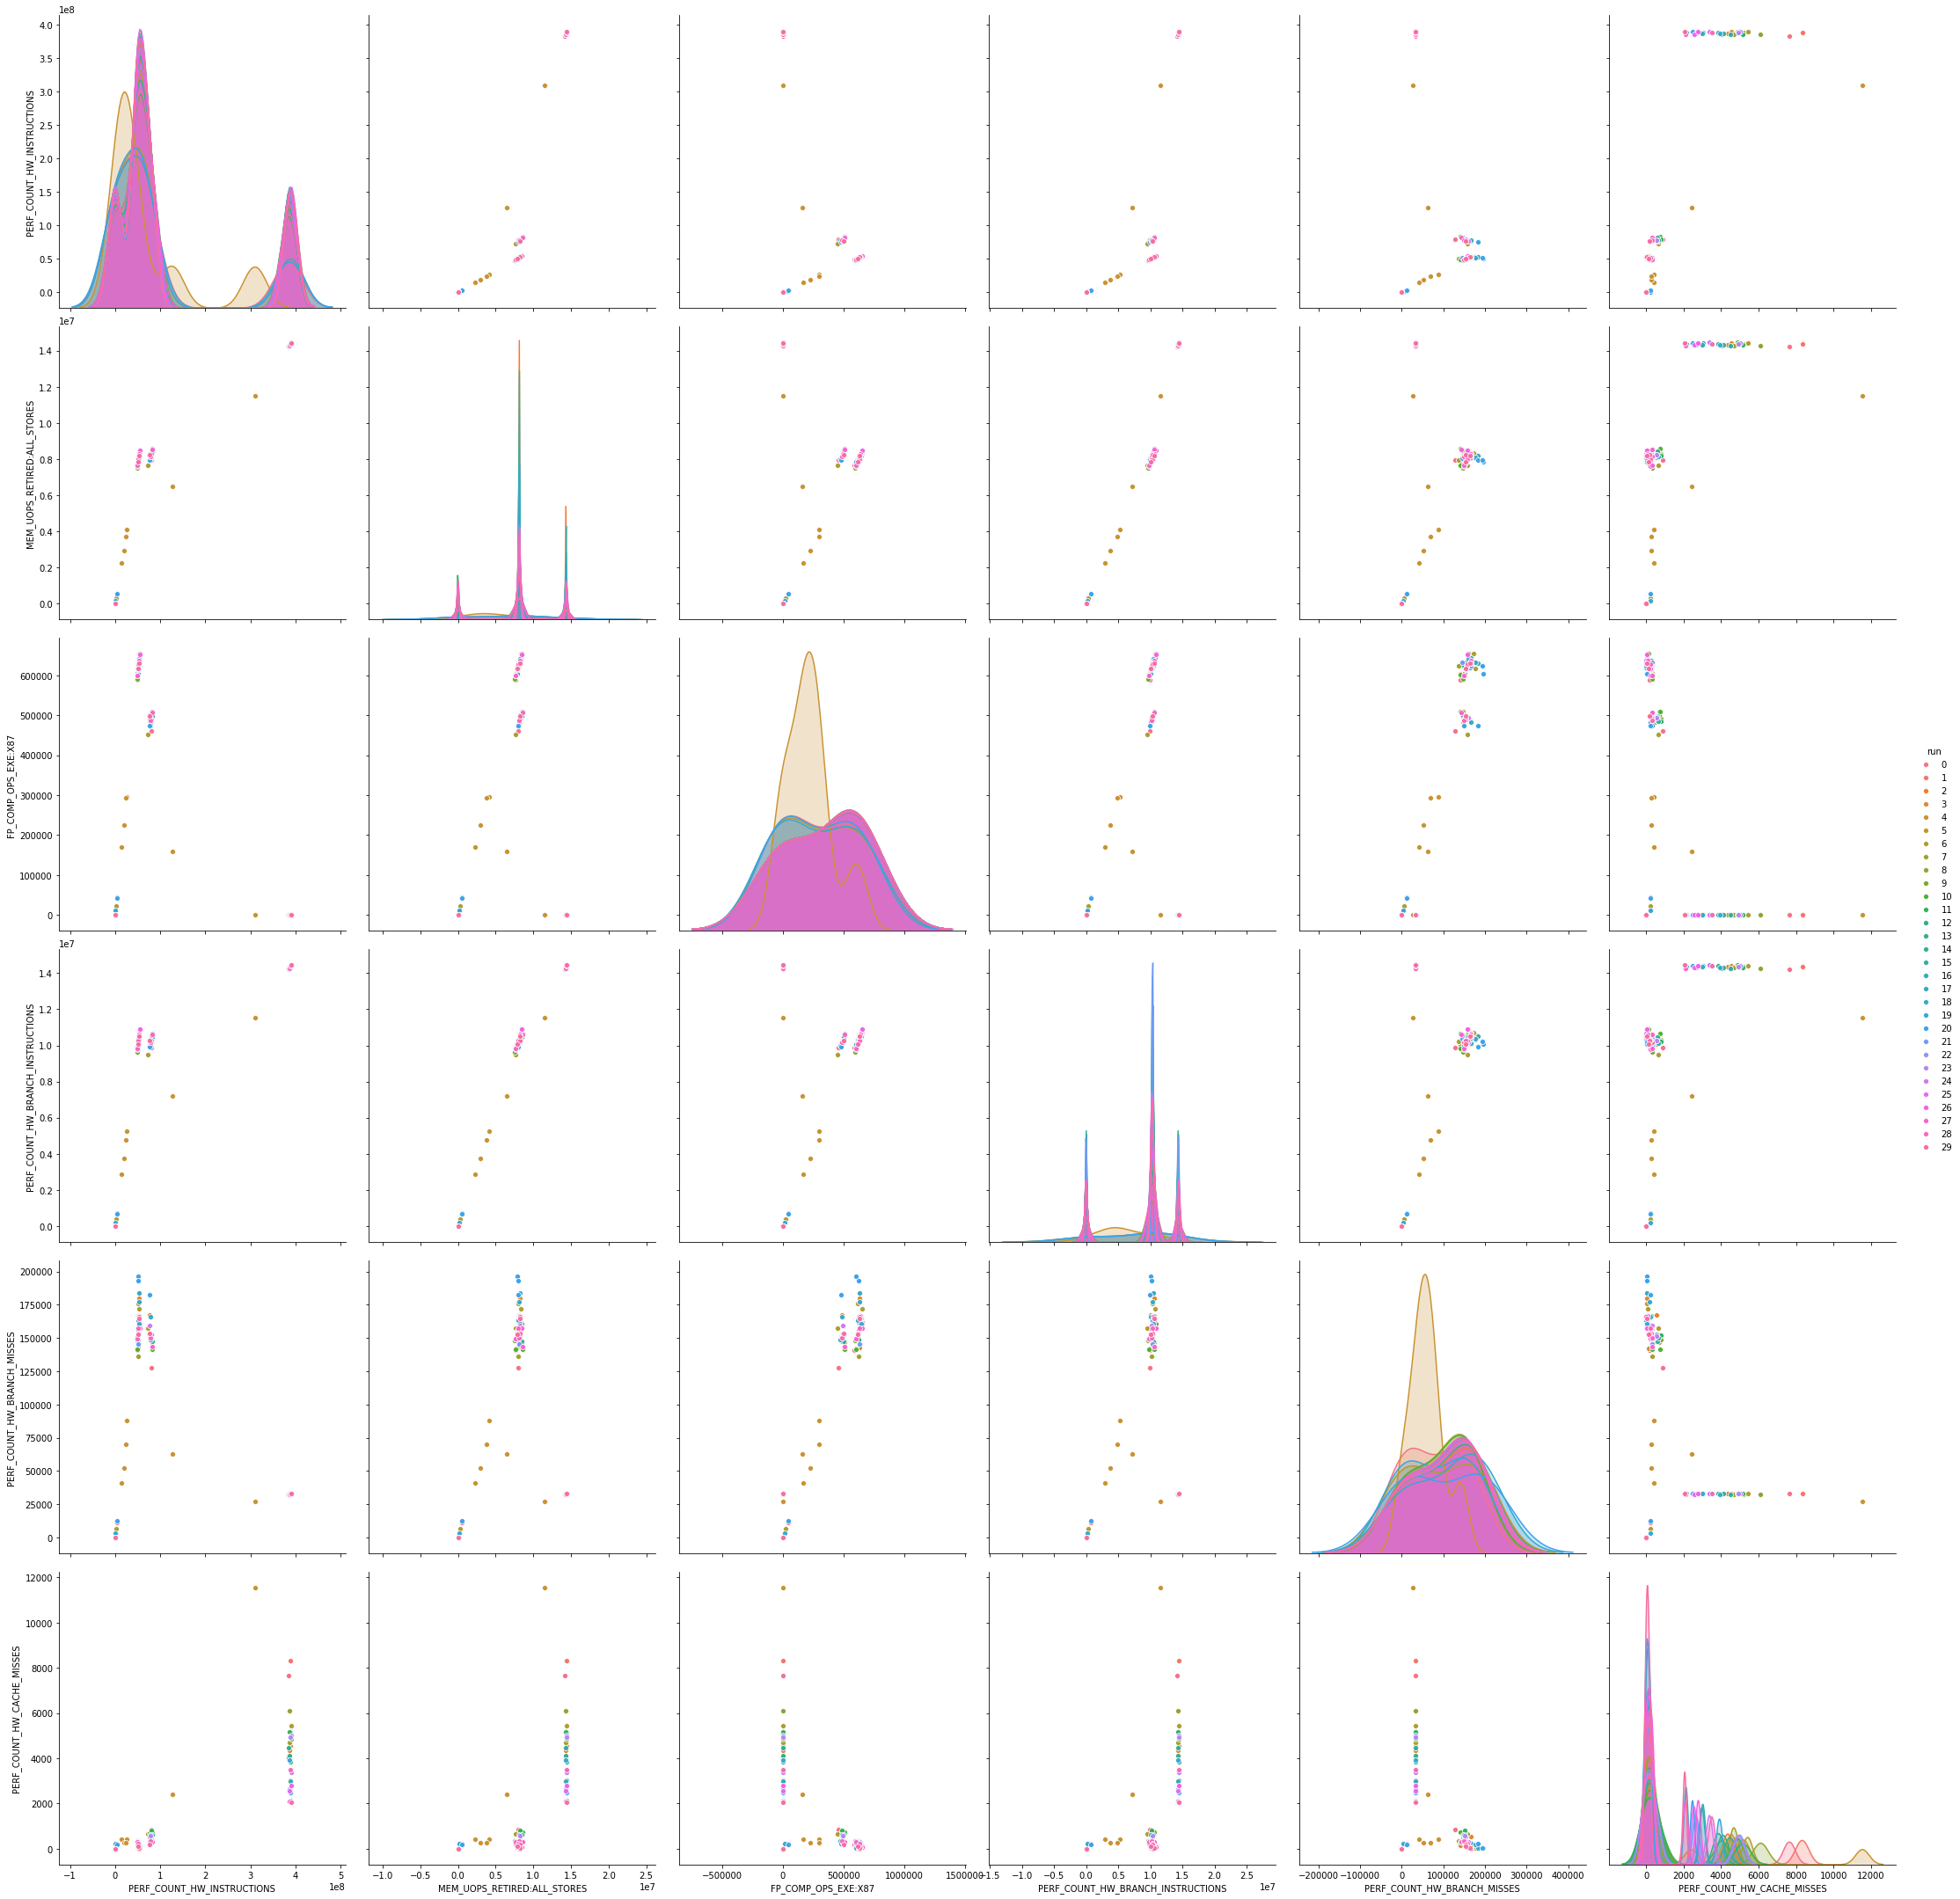

In [8]:
big_df=pd.DataFrame()
for i, df in enumerate(dfs):
    df['run']= i
    big_df= pd.concat([big_df,df])
big_df.head(5)
import seaborn as sns
sns_plot= sns.pairplot(big_df,vars=['PERF_COUNT_HW_INSTRUCTIONS','MEM_UOPS_RETIRED:ALL_STORES','FP_COMP_OPS_EXE:X87',
                                   'PERF_COUNT_HW_BRANCH_INSTRUCTIONS', 'PERF_COUNT_HW_BRANCH_MISSES', 'PERF_COUNT_HW_CACHE_MISSES'], hue="run",size=5)
#sns_plot.savefig("output.png")